### 実行したマシンの情報を取得する関数を定義

In [1]:
import platform
import multiprocessing as mp
import timeit

def print_sysinfo():
    print( '\nPython version  :', platform.python_version() )
    print( 'compiler        :', platform.python_compiler() )
    
    print( '\nsystem     :', platform.system() )
    print( 'release    :', platform.release() )
    print( 'machine    :', platform.machine() )
    print( 'processor  :', platform.processor() )
    print( 'CPU count  :', mp.cpu_count() )
    print( 'interpreter:', platform.architecture()[0] )
    print

In [2]:
print_sysinfo()


Python version  : 3.6.1
compiler        : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)

system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU count  : 4
interpreter: 64bit


### Daskを使った簡単な並列処理

以下に簡単な計算例を示す。

In [3]:
from time import sleep

def slowadd(x,y):
    """ addをスローで行う """
    sleep(1)
    return x+y

def slowinc(x):
    """ incrementをスローで行う """
    sleep(1)
    return x+1

def slowsum(L):
    """ sumをスローで行う """
    sleep(1)
    return sum(L)

実行後は以下のようになる。スリープで遅延させているため処理時間は１sとなる。

In [4]:
%time slowsum([1,2,3])

CPU times: user 1.09 ms, sys: 1.27 ms, total: 2.36 ms
Wall time: 1 s


6

上記で宣言した関数を用いて簡単な処理を書く。  
リストを３つ作成し中身を足して行くだけの簡単な処理である。  
実行には12sほどかかっている。

In [5]:
%%time

data = [1,2,3]
A = [slowinc(i) for i in data]
B = [slowadd(a,10) for a in A]
C = [slowadd(b,100) for b in B]
score = slowsum(A) + slowsum(B) + slowsum(C)

print(score)

387
CPU times: user 1.61 ms, sys: 1.7 ms, total: 3.32 ms
Wall time: 12 s


### Daskを使って並列化

In [6]:
from dask import delayed

In [7]:
%%time

data = [1,2,3]
A = [delayed(slowinc)(i) for i in data]
B = [delayed(slowadd)(b,10) for b in A]
C = [delayed(slowadd)(c,100) for c in B]
score = delayed(slowsum)(A) + delayed(slowsum)(B) + delayed(slowsum)(C)

print(score)

Delayed('add-cc9841fc754e616e60fc253ad82932d7')
CPU times: user 1.94 ms, sys: 501 µs, total: 2.44 ms
Wall time: 2.76 ms


処理時間は短くなっているがここでは計算は行なっておらず、グラフのマッピングを行なっている。  
以下にグラフのマッピング結果を示す。

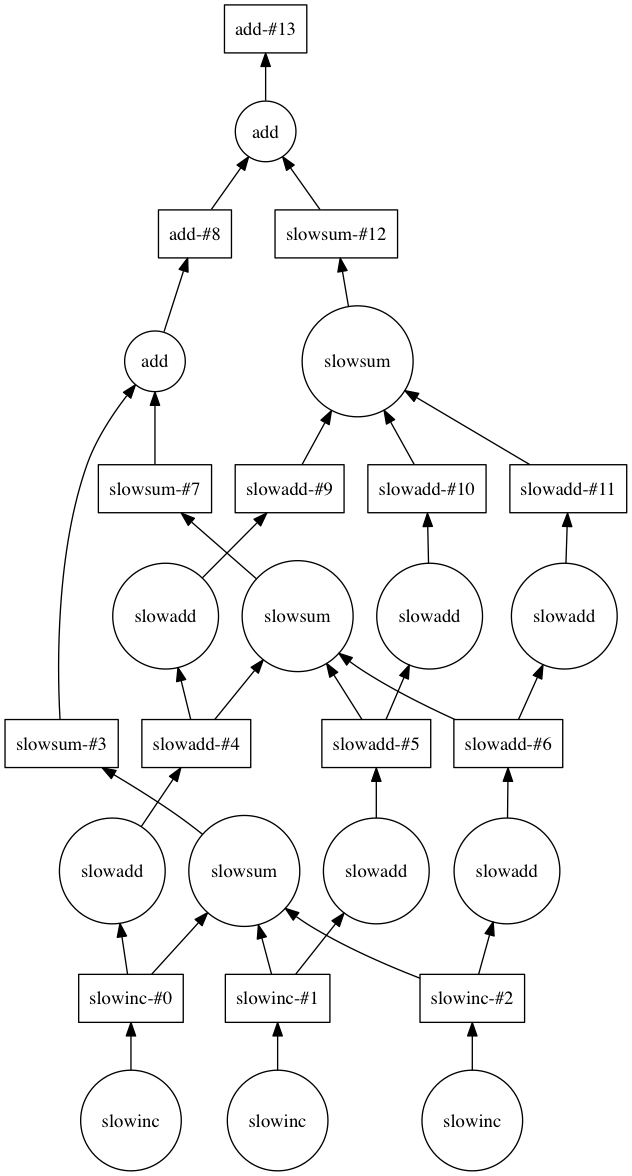

In [10]:
score.visualize()

In [8]:
%%time
score.compute()

CPU times: user 10.8 ms, sys: 5.16 ms, total: 15.9 ms
Wall time: 4.04 s


387

daskでは並列処理のマッピングを自動で行ってくれるらしい

### bokehを使って処理段階を描写

In [44]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [45]:
from dask.diagnostics import Profiler
prof = Profiler()

with prof:
    score.compute()

prof.visualize()

Figure(id='6cb362df-6c8f-4d49-b102-a5a9b3ae323f', ...)

### 並列化の処理を手動で行う

### モンテカルロ法

In [ ]:
import random

In [42]:
def non_paralel_monte(num):
    counter = 0
    for i in range(num):
        x = random.random()
        y = random.random()
        if x**2 + y**2 < 1:
            counter += 1
    pi = 4*counter/num
    return pi

In [43]:
%%time
non_paralel_monte(10000000)

CPU times: user 5.51 s, sys: 66.7 ms, total: 5.58 s
Wall time: 5.82 s


3.1417588

並列実装なしで点を1000万個プロットした場合、処理時間は約6sとなっている。

#### モンテカルロを並列実装

In [ ]:
def paralel_monte(num):
    counter = 0
    for i in range(num):
        x,y = random.random(),random.random()
        if x**2 + y**2 < 1:
            counter += 1
    pi = 4*counter/num
    return pi